- Training set: First 160 + 1 = **161 images** from original training set
- Test set: Remaining **48 images** from original training set

In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, Dataset, Subset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision import transforms, models

Define Custom Dataset Class

Same dataset class as Task 1, but we'll use only `train_catvnoncat.h5` for both training and testing.

In [2]:
class CatDataset(Dataset):
    """
    Custom dataset class for loading cat/non-cat images from h5 files.
    Applies transformations to prepare images for ResNet-18.
    """
    def __init__(self, h5_path, transform=None):
        # Load the h5 file containing images and labels
        with h5py.File(h5_path, 'r') as f:
            # Load training set (209 images total)
            self.images = np.array(f['train_set_x'])
            self.labels = np.array(f['train_set_y'])

        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Get image at index idx
        image = self.images[idx]
        label = float(self.labels[idx])

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Pipeline for preprocessing of the image
transform = transforms.Compose([
    # Convert numpy array (H x W x C) to PIL Image
    transforms.ToPILImage(),

    # Resize to 224x224 to match ImageNet input size
    transforms.Resize((224, 224)),

    # Randomly flip images horizontally for data augmentation (50% probability)
    transforms.RandomHorizontalFlip(),

    # Convert PIL Image to PyTorch tensor with shape (C x H x W)
    transforms.ToTensor(),

    # Normalize using ImageNet dataset statistics
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Splitinf the data


In [4]:
# SBU Student ID
last_digit = 1
split_point = 160 + last_digit

print(f"Student ID last digit: {last_digit}")
print(f"Training set size: {split_point} images (indices 0-{split_point-1})")
print(f"Test set size: {209 - split_point} images (indices {split_point}-208)")
print(f"Original test set (50 images): DISCARDED\n")

# Load full dataset from train_catvnoncat.h5 only
full_dataset = CatDataset('train_catvnoncat.h5', transform=transform)

# Create indices for train and test splits
train_indices = list(range(split_point))  # 0 to 160 (161 images)
test_indices = list(range(split_point, 209))  # 161 to 208 (48 images)

# Create Subset datasets using the indices
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training samples loaded: {len(train_dataset)}")
print(f"Test samples loaded: {len(test_dataset)}")

Student ID last digit: 1
Training set size: 161 images (indices 0-160)
Test set size: 48 images (indices 161-208)
Original test set (50 images): DISCARDED

Training samples loaded: 161
Test samples loaded: 48


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Move model to GPU if available
model = model.to(device)

In [7]:
# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer with learning rate 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Number of training epochs
num_epochs = 20

Train the model and track both training loss and accuracy.

In [8]:
# Track training history
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches in training set
    for images, labels in train_loader:
        # Move data to GPU if available
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy for this batch
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Update learning rate
    scheduler.step()

    # Print progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("\nTraining completed!")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")

Epoch [2/20], Loss: 0.4976, Accuracy: 0.8509
Epoch [4/20], Loss: 0.3196, Accuracy: 0.9565
Epoch [6/20], Loss: 0.2296, Accuracy: 0.9876
Epoch [8/20], Loss: 0.2361, Accuracy: 0.9689
Epoch [10/20], Loss: 0.2150, Accuracy: 0.9752
Epoch [12/20], Loss: 0.2142, Accuracy: 0.9814
Epoch [14/20], Loss: 0.1954, Accuracy: 0.9938
Epoch [16/20], Loss: 0.2237, Accuracy: 0.9689
Epoch [18/20], Loss: 0.1885, Accuracy: 0.9938
Epoch [20/20], Loss: 0.2038, Accuracy: 0.9876

Training completed!
Final Training Accuracy: 0.9876


Calculate test accuracy and identify misclassified images.

In [9]:
# Set model to evaluation mode
model.eval()

# Lists to store predictions and ground truth
all_predictions = []
all_labels = []
all_outputs = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).squeeze()

        # Get predictions
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate test accuracy
test_accuracy = np.mean(all_predictions == all_labels)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Find indices of misclassified images
# Note: These indices are relative to the test set (0-47)
# To get original dataset indices, add split_point
misclassified_test_indices = np.where(all_predictions != all_labels)[0]
misclassified_original_indices = misclassified_test_indices + split_point

print(f"\nNumber of misclassified images: {len(misclassified_test_indices)}")
print(f"Misclassified test indices (0-{len(test_dataset)-1}): {misclassified_test_indices.tolist()}")
print(f"Corresponding original dataset indices ({split_point}-208): {misclassified_original_indices.tolist()}")

Test Set Accuracy: 0.9375

Number of misclassified images: 3
Misclassified test indices (0-47): [4, 24, 36]
Corresponding original dataset indices (161-208): [165, 185, 197]


Visualize at least 4 failed cases from the test set.

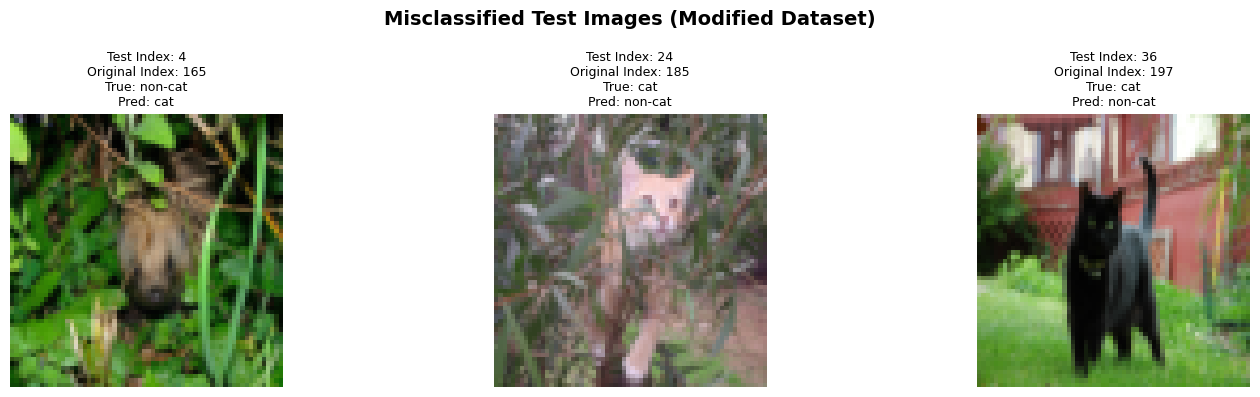

In [10]:
# Display up to 4 misclassified images
num_display = min(4, len(misclassified_test_indices))

if num_display > 0:
    fig, axes = plt.subplots(1, num_display, figsize=(15, 4))

    # Handle case where there's only 1 misclassified image
    if num_display == 1:
        axes = [axes]

    # Load original images from train_catvnoncat.h5
    with h5py.File('train_catvnoncat.h5', 'r') as f:
        all_images = np.array(f['train_set_x'])

    for i, test_idx in enumerate(misclassified_test_indices[:num_display]):
        # Convert test index to original dataset index
        original_idx = test_idx + split_point

        # Get original image
        img = all_images[original_idx]
        true_label = int(all_labels[test_idx])
        pred_label = int(all_predictions[test_idx])

        # Class names
        class_names = ['non-cat', 'cat']

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Test Index: {test_idx}\nOriginal Index: {original_idx}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                         fontsize=9)
        axes[i].axis('off')

    plt.suptitle('Misclassified Test Images (Modified Dataset)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("All test images were classified correctly!")

Visualize training loss and accuracy over epochs.

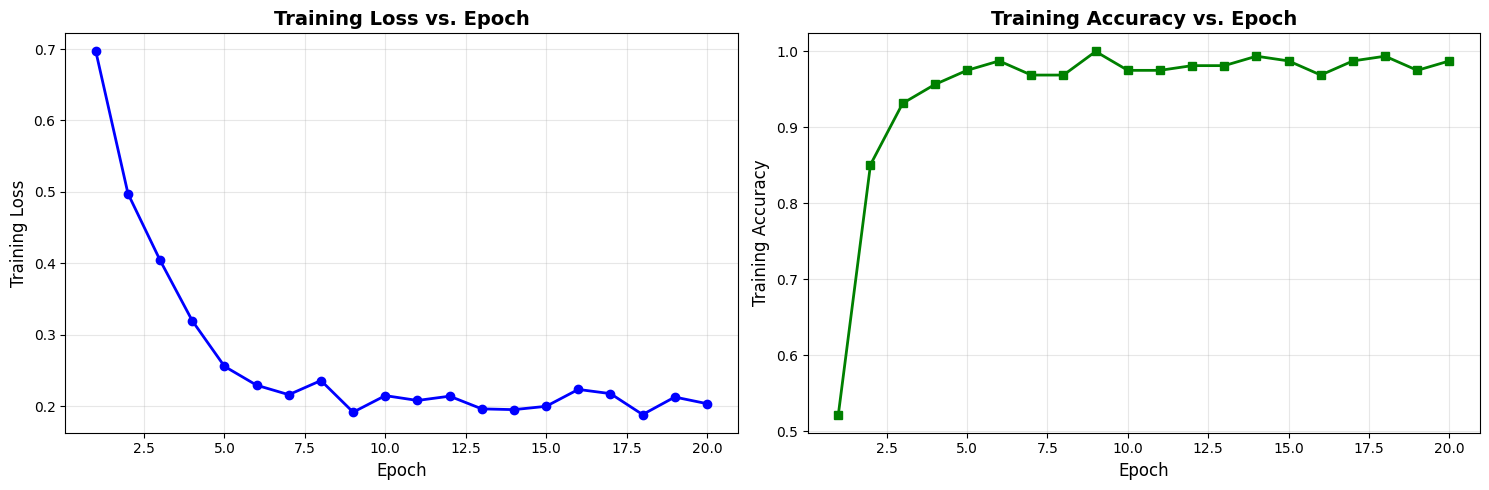

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(range(1, num_epochs + 1), train_losses, marker='o', linewidth=2, color='blue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss vs. Epoch', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot training accuracy
ax2.plot(range(1, num_epochs + 1), train_accuracies, marker='s', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Accuracy', fontsize=12)
ax2.set_title('Training Accuracy vs. Epoch', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The reduced training set size (161 vs. 209) impact model performance compared to Task 1, as the model has less data to learn from.